TensorFlow Version: 2.19.0
Using GPU: True

Loading Malaria Dataset...


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/incomplete.UY25KM_1.0.0/malaria-train.tfrecord*...:   0%|         …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Starting Professional Training...
Epoch 1/5
345/345 ━━━━━━━━━━━━━━━━━━━━ 312s 746ms/step - accuracy: 0.7780 - loss: 0.4674 - val_accuracy: 0.9045 - val_loss: 0.2627
Epoch 2/5
345/345 ━━━━━━━━━━━━━━━━━━━━ 24s 69ms/step - accuracy: 0.9125 - loss: 0.2348 - val_accuracy: 0.9151 - val_loss: 0.2371
Epoch 3/5
345/345 ━━━━━━━━━━━━━━━━━━━━ 24s 69ms/step - accuracy: 0.9224 - loss: 0.2122 - val_accuracy: 0.9209 - val_loss: 0.2136
Epoch 4/5
345/345 ━━━━━━━━━━━━━━━━━━━━ 24s 70ms/step - accuracy: 0.9261 - loss: 0.1986 - val_accuracy: 0.9274 - val_loss: 0.2028
Epoch 5/5
345/345 ━━━━━━━━━━━━━━━━━━━━ 24s 69ms/step - accuracy: 0.9286 - loss: 0.1906 - val_accuracy: 0.9260 - val_loss: 0.1963

Generating Report...


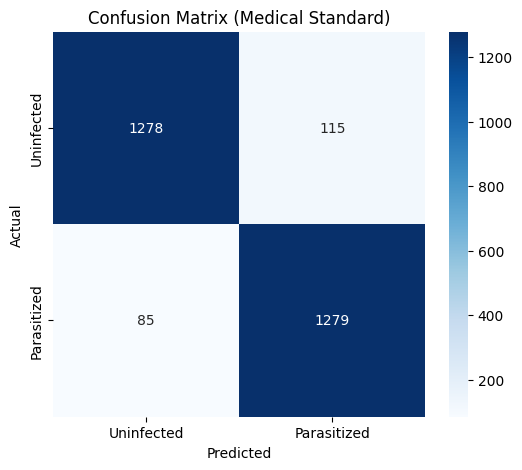


Classification Report:

              precision    recall  f1-score   support

  Uninfected       0.94      0.92      0.93      1393
 Parasitized       0.92      0.94      0.93      1364

    accuracy                           0.93      2757
   macro avg       0.93      0.93      0.93      2757
weighted avg       0.93      0.93      0.93      2757

Upgrade Complete. Model saved as 'malaria_mobilenet_v2.keras'


In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# --- 1. SETUP & SPEED OPTIMIZATION ---
# Enable Mixed Precision (Makes training 2x faster on T4 GPU)
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

print(f"TensorFlow Version: {tf.__version__}")
print(f"Using GPU: {len(tf.config.list_physical_devices('GPU')) > 0}")

# --- 2. DATA PIPELINE (Standard Medical Benchmark) ---
print("\nLoading Malaria Dataset...")
dataset, info = tfds.load('malaria', split='train', as_supervised=True, with_info=True)

def preprocess(image, label):
    image = tf.image.resize(image, (224, 224)) # MobileNetV2 expects 224x224
    image = tf.cast(image, tf.float32) / 255.0 # Normalize
    return image, label

# Split Data: 80% Train, 10% Validation, 10% Test
train_size = int(0.8 * info.splits['train'].num_examples)
val_size = int(0.1 * info.splits['train'].num_examples)

train_ds = dataset.take(train_size)
remaining = dataset.skip(train_size)
val_ds = remaining.take(val_size)
test_ds = remaining.skip(val_size)

# Optimization pipeline
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

# Add Data Augmentation (Flips/Rotations) only to Training
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

def augment(image, label):
    return data_augmentation(image), label

train_ds = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(augment, num_parallel_calls=AUTOTUNE) # Apply Augmentation
train_ds = train_ds.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds = val_ds.map(preprocess, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = test_ds.map(preprocess, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# --- 3. MODEL: TRANSFER LEARNING (MobileNetV2) ---
# We download the "Brain" of MobileNetV2 but cut off the top (classification) layer
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False # Freeze the base model so we don't destroy pre-trained patterns

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid', dtype='float32') # Ensure output is float32
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# --- 4. TRAIN ---
print("\nStarting Professional Training...")
history = model.fit(train_ds, epochs=5, validation_data=val_ds)

# --- 5. PROFESSIONAL EVALUATION ---
print("\nGenerating Report...")

# Get predictions
y_true = []
y_pred = []

for img, label in test_ds:
    y_true.extend(label.numpy())
    preds = model.predict(img, verbose=0)
    y_pred.extend((preds > 0.5).astype(int).flatten())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Medical Standard)')
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=['Uninfected', 'Parasitized']))

# Save
model.save('malaria_mobilenet_v2.keras')
print("Upgrade Complete. Model saved as 'malaria_mobilenet_v2.keras'")